In [1]:
from cirq import Circuit, LineQubit, Simulator, plot_state_histogram, inverse
from cirq import CNOT, H, measure, X, Z
import matplotlib.pyplot as plt

In [2]:
def xor(q1: LineQubit, q2: LineQubit, output: LineQubit):
    return [CNOT(q1, output),
            CNOT(q2, output)]

In [3]:
def xors(inputs: list[LineQubit], ancilla: list[LineQubit]):
    return [xor(inputs[0], inputs[1], ancilla[0]),
            xor(inputs[1], inputs[3], ancilla[1]),
            xor(inputs[0], inputs[2], ancilla[2]),
            xor(inputs[2], inputs[3], ancilla[3])]

In [4]:
def sudoku_oracle(inputs: list[LineQubit], ancilla: list[LineQubit], output: LineQubit):
    comp = xors(inputs, ancilla)

    return [comp,
            X.controlled(4).on(*ancilla, output),
            inverse(comp)]

In [5]:
def reflect_zero(inputs: list[LineQubit]):
    length = len(inputs)

    return [X.on_each(inputs),
            Z.controlled(length - 1).on(*inputs[:length - 1], inputs[-1]),
            inverse(X.on_each(inputs))]

In [6]:
from cirq.ops import OP_TREE

def reflect_initial(init_op: OP_TREE, qubits: list[LineQubit]):
    return [inverse(init_op), reflect_zero(qubits), init_op]

In [7]:
def grover_circuit():
    inputs = [LineQubit(i) for i in range(4)]
    ancilla = [LineQubit(i + 4) for i in range(4)]
    pkb = LineQubit(8)

    c = Circuit()

    prepare_initial_state = H.on_each(inputs)

    c.append(prepare_initial_state)
    c.append([X(pkb), H(pkb)])
    c.concat_ragged()

    for _ in range(2):
        c.append(sudoku_oracle(inputs, ancilla, pkb))
        c.append(reflect_initial(prepare_initial_state, inputs))

    c.append(measure(*inputs, key="result"))

    return c

In [8]:
c = grover_circuit()

print('Circuit:')
print(c)

Circuit:
              ┌──┐   ┌──┐   ┌──┐               ┌──┐   ┌───┐   ┌───┐   ┌──┐                           ┌──┐   ┌──┐   ┌──┐               ┌──┐   ┌───┐   ┌───┐   ┌──┐
0: ───H───@─────@──────────────────────────────────────────────@───────@─────H───X───@───X───H───@─────@──────────────────────────────────────────────@───────@─────H───X───@───X───H───M('result')───
          │     │                                              │       │             │           │     │                                              │       │             │           │
1: ───H───┼────@┼─────@─────────────────────────────────@──────┼@──────┼H────X───────@───X───H───┼────@┼─────@─────────────────────────────────@──────┼@──────┼H────X───────@───X───H───M─────────────
          │    ││     │                                 │      ││      │             │           │    ││     │                                 │      ││      │             │           │
2: ───H───┼────┼┼─────┼@──────@─────────────────@──────@┼──

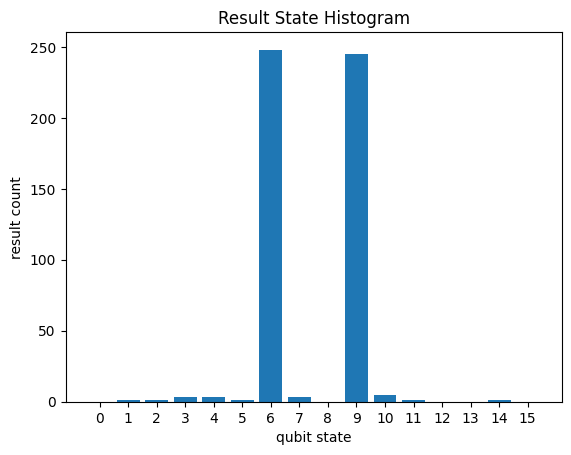

In [10]:
result = Simulator().run(c, repetitions=512)
plot_state_histogram(result, plt.subplot())

plt.show()